In [1]:
import sys,os,pandas,numpy,seaborn

import scipy,scipy.stats

import matplotlib,matplotlib.pyplot
matplotlib.rcParams.update({'font.size':40,'font.family':'Arial','xtick.labelsize':20,'ytick.labelsize':20,'axes.labelsize':33})
matplotlib.rcParams['pdf.fonttype']=42

# 0. user defined variables

In [2]:
kallisto_dir='/Volumes/omics4tb2/alomana/projects/TLR/data/ecoli/kallisto1e3/'

In [3]:
metadata={}
metadata['SRR4023274']='fp.rep.1'
metadata['SRR4023275']='fp.rep.2'
metadata['SRR4023276']='fp.rep.3'
metadata['SRR4023277']='mrna.rep.1'
metadata['SRR4023278']='mrna.rep.2'
metadata['SRR4023279']='mrna.rep.3'

# 1. read files

In [4]:
myList=[]
for sample in metadata.keys():
    print(sample)
    input_file=kallisto_dir+sample+'/abundance.tsv'
    print(input_file)
    df=pandas.read_csv(input_file,sep='\t',index_col=0)
    df.index.name='geneID'
    df.rename(columns={"tpm": "{}".format(metadata[sample])},inplace=True)
    df.drop(columns=['length','eff_length',"est_counts"],inplace=True)
    myList.append(df)
    print(df.head())
    print(df.shape)
    print()

SRR4023274
/Volumes/omics4tb2/alomana/projects/TLR/data/ecoli/kallisto1e3/SRR4023274/abundance.tsv
            fp.rep.1
geneID              
VIMSS14146    0.0000
VIMSS14147   12.3933
VIMSS14148   14.0365
VIMSS14149   43.1294
VIMSS14150    0.0000
(4611, 1)

SRR4023275
/Volumes/omics4tb2/alomana/projects/TLR/data/ecoli/kallisto1e3/SRR4023275/abundance.tsv
            fp.rep.2
geneID              
VIMSS14146    0.0000
VIMSS14147  205.2070
VIMSS14148   86.7488
VIMSS14149  214.9260
VIMSS14150   10.3839
(4611, 1)

SRR4023276
/Volumes/omics4tb2/alomana/projects/TLR/data/ecoli/kallisto1e3/SRR4023276/abundance.tsv
             fp.rep.3
geneID               
VIMSS14146    0.00000
VIMSS14147  127.94000
VIMSS14148   57.57790
VIMSS14149  167.04900
VIMSS14150    1.60524
(4611, 1)

SRR4023277
/Volumes/omics4tb2/alomana/projects/TLR/data/ecoli/kallisto1e3/SRR4023277/abundance.tsv
            mrna.rep.1
geneID                
VIMSS14146     0.00000
VIMSS14147    31.62330
VIMSS14148    60.90370
VIMSS141

In [5]:
df=pandas.concat(myList,axis=1)
print(df.shape)
df.head()

(4611, 6)


,fp.rep.1,fp.rep.2,fp.rep.3,mrna.rep.1,mrna.rep.2,mrna.rep.3
geneID,,,,,,
VIMSS14146,0.0000,0.0000,0.00000,0.00000,0.00000,0.0000
VIMSS14147,12.3933,205.2070,127.94000,31.62330,105.08000,129.6160
VIMSS14148,14.0365,86.7488,57.57790,60.90370,95.91590,99.1333
VIMSS14149,43.1294,214.9260,167.04900,66.15170,96.50890,110.7040
VIMSS14150,0.0000,10.3839,1.60524,5.66789,9.64829,13.0698


# 2. analysis

## 2.1. noise

/Users/alomana/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/Users/alomana/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


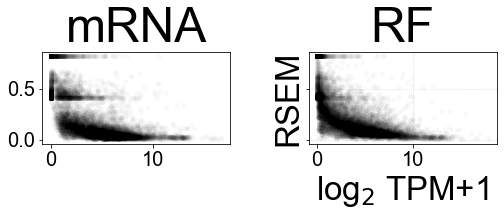

In [6]:
transcriptx=[]; transcripty=[]
footprintx=[]; footprinty=[]
gene_names=df.index.to_list()

for gene_name in gene_names:
    
    # data transformation
    log2M=numpy.log2(numpy.array(df.loc[gene_name,['mrna.rep.1','mrna.rep.2','mrna.rep.3']]+1))
    log2F=numpy.log2(numpy.array(df.loc[gene_name,['fp.rep.1','fp.rep.2','fp.rep.3']]+1))
    
    # error
    sem=numpy.std(log2M)/numpy.sqrt(len(log2M))
    rsem_mRNA=sem/numpy.mean(log2M)
    
    sem=numpy.std(log2F)/numpy.sqrt(len(log2F))
    rsem_RF=sem/numpy.mean(log2F)
    
    # appending
    transcriptx.append(log2M); transcripty.append(rsem_mRNA)
    footprintx.append(log2F); footprinty.append(rsem_RF)
    

# plot
fig, (ax1, ax2) = matplotlib.pyplot.subplots(1,2, figsize=(8,4), sharey=True)

ax1.plot(transcriptx,transcripty,'o',color='black',alpha=0.025,ms=5,mew=0,label='mRNA')
ax1.set_title('mRNA')

ax2.plot(footprintx,footprinty,'o',color='black',alpha=0.025,ms=5,mew=0,label='FP')
ax2.set_title('RF')
    
matplotlib.pyplot.xlabel('log$_{2}$ TPM+1')
matplotlib.pyplot.ylabel('RSEM')

matplotlib.pyplot.grid(True,alpha=0.5,ls=':')
matplotlib.pyplot.tight_layout()

## 2.2. discriminating

In [7]:
rsem_threshold=1/3

In [8]:
gene_names=df.index.to_list()
print('number of elements:',len(gene_names))

setx=[]; sety=[]
hollowx=[]; hollowy=[]

for gene_name in gene_names:
    
    # data transformation
    log2M=numpy.log2(numpy.array(df.loc[gene_name,['mrna.rep.1','mrna.rep.2','mrna.rep.3']]+1))
    log10M=numpy.log10(numpy.array(df.loc[gene_name,['mrna.rep.1','mrna.rep.2','mrna.rep.3']]+1))
    log2F=numpy.log2(numpy.array(df.loc[gene_name,['fp.rep.1','fp.rep.2','fp.rep.3']]+1))
    
    # noise
    if numpy.max(log2M) > numpy.log2(10+1): # if expression is below 10 TPMs, don't consider noise
        sem=numpy.std(log2M)/numpy.sqrt(len(log2M))
        rsem_mRNA=sem/numpy.mean(log2M)
    else:
        rsem_mRNA=0

    if numpy.max(log2F) > numpy.log2(10+1): # if expression is below 10 TPMs, don't consider noise
        sem=numpy.std(log2F)/numpy.sqrt(len(log2F))
        rsem_RF=sem/numpy.mean(log2F)
    else:
        rsem_RF=0
        
    # medians and ratio
    m=numpy.median(log10M)
    r=numpy.median(log2F)-numpy.median(log2M)
    
    # exclude zero values
    if numpy.max([m,r]) > 0:
    
        # differenciate between trasncripts with or without footprints or inverse
        if numpy.median(log2F) == 0:
            if rsem_mRNA < rsem_threshold:
                hollowx.append(m); hollowy.append(r)
        elif numpy.median(log2M) == 0:
            if rsem_RF < rsem_threshold:
                hollowx.append(m); hollowy.append(r)
        else:
            if rsem_mRNA < rsem_threshold and rsem_RF < rsem_threshold:        
                setx.append(m); sety.append(r)     

number of elements: 4611


## 2.3 regression model

In [9]:
print('number of elements:',len(setx))
# perform regression analysis
print('\t regression results:')
slope,intercept,r_value,p_value,std_err=scipy.stats.linregress(setx,sety)
print('\t\t slope',slope)
print('\t\t intercept',intercept)
print('\t\t r_value',r_value)
print('\t\t pvalue',p_value)
print('\t\t std_err',std_err)

# compute for the model
m=slope
c=intercept
expected=list(m*numpy.array(setx)+c)

number of elements: 3263
	 regression results:
		 slope 0.10072602440006166
		 intercept -0.7356798453758275
		 r_value 0.07587866377675116
		 pvalue 1.4314052346827311e-05
		 std_err 0.023178896984650792


# 3. plot

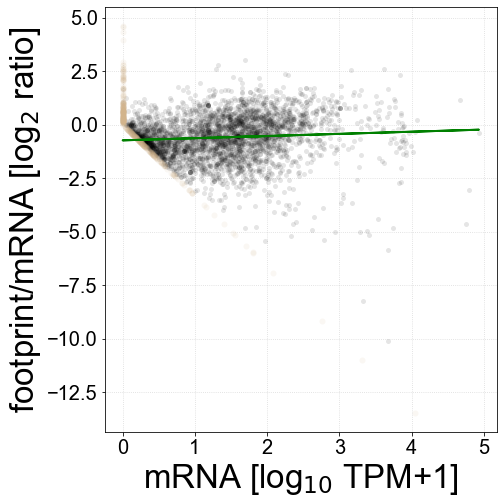

In [10]:
matplotlib.pyplot.figure(None,(8,8))

matplotlib.pyplot.plot(setx,sety,'o',color='black',alpha=0.1,ms=5,mew=0)
matplotlib.pyplot.plot(hollowx,hollowy,'o',alpha=0.1,mew=0,color='tan')

matplotlib.pyplot.xlabel('mRNA [log$_{10}$ TPM+1]')
matplotlib.pyplot.ylabel('footprint/mRNA [log$_{2}$ ratio]')
matplotlib.pyplot.plot(setx,expected,'-',lw=2,color='green')

matplotlib.pyplot.grid(True,alpha=0.5,ls=':')
matplotlib.pyplot.tight_layout()

## 3.2. blocks

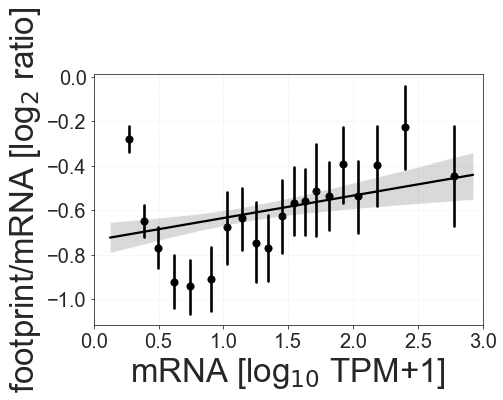

In [11]:
seaborn.set_style("ticks")
matplotlib.pyplot.figure(None,(8,6))

seaborn.regplot(x=setx,y=sety,x_bins=20,order=1,color='black')

matplotlib.pyplot.xlim([0,3])
matplotlib.pyplot.xlabel('mRNA [log$_{10}$ TPM+1]')
matplotlib.pyplot.ylabel('footprint/mRNA [log$_{2}$ ratio]')

matplotlib.pyplot.grid(True,alpha=0.5,ls=':')
matplotlib.pyplot.tight_layout()

matplotlib.pyplot.savefig('figure.pdf')

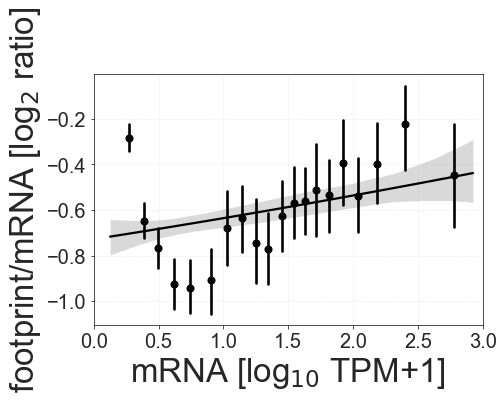

In [12]:
seaborn.set_style("ticks")
matplotlib.pyplot.figure(None,(8,6))

seaborn.regplot(x=setx,y=sety,x_bins=20,order=2,color='black')

matplotlib.pyplot.xlim([0,3])
matplotlib.pyplot.xlabel('mRNA [log$_{10}$ TPM+1]')
matplotlib.pyplot.ylabel('footprint/mRNA [log$_{2}$ ratio]')

matplotlib.pyplot.grid(True,alpha=0.5,ls=':')
matplotlib.pyplot.tight_layout()

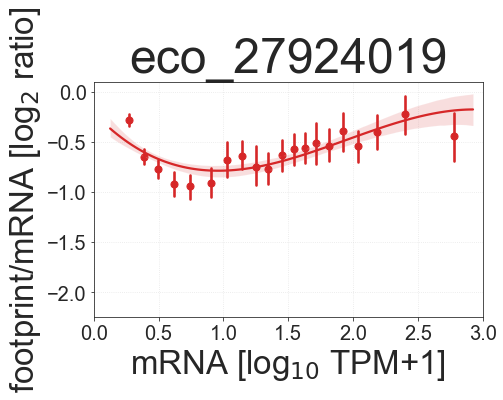

In [15]:
seaborn.set_style("ticks")
matplotlib.pyplot.figure(None,(8,6))

seaborn.regplot(x=setx,y=sety,x_bins=20,order=3,color='tab:red')

matplotlib.pyplot.xlim([0,3])
ub=0.1; lb=-2.25
matplotlib.pyplot.ylim([lb,ub])

matplotlib.pyplot.xlabel('mRNA [log$_{10}$ TPM+1]')
matplotlib.pyplot.ylabel('footprint/mRNA [log$_{2}$ ratio]')
matplotlib.pyplot.title('eco_27924019')

matplotlib.pyplot.grid(True,alpha=0.5,ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.savefig('figure.eco_27924019.pdf')